In [ ]:
import carla
import random
import time
import numpy as np

# Connect to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.get_world()

# Set synchronous mode (recommended for Traffic Manager)
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.05
world.apply_settings(settings)

# Set up Traffic Manager in synchronous mode
traffic_manager = client.get_trafficmanager()
traffic_manager.set_synchronous_mode(True)
traffic_manager.set_random_device_seed(0)
random.seed(0)

# Get blueprints for vehicles
blueprint_library = world.get_blueprint_library()
vehicle_blueprints = blueprint_library.filter('vehicle.*')

# Get spawn points
spawn_points = world.get_map().get_spawn_points()
if not spawn_points:
    raise RuntimeError("No spawn points available")

# --- Spawn your ego vehicle (Mini Cooper) ---
vehicle_bp = blueprint_library.find('vehicle.mini.cooper')
if vehicle_bp is None:
    raise RuntimeError("Mini Cooper blueprint not found!")
ego_spawn_point = random.choice(spawn_points)
ego_vehicle = world.try_spawn_actor(vehicle_bp, ego_spawn_point)
if ego_vehicle is None:
    raise RuntimeError("Failed to spawn Mini Cooper!")

# Remove ego vehicle's spawn point from the list to avoid collision at start
spawn_points = [sp for sp in spawn_points if sp.location.distance(ego_spawn_point.location) > 2.0]

# --- Spawn traffic vehicles ---
num_traffic = min(29, len(spawn_points))  # 1 ego + 29 traffic = 30 total
traffic_vehicles = []
for i in range(num_traffic):
    blueprint = random.choice(vehicle_blueprints)
    spawn_point = spawn_points[i]
    vehicle = world.try_spawn_actor(blueprint, spawn_point)
    if vehicle:
        traffic_vehicles.append(vehicle)

# Register all traffic vehicles with Traffic Manager
tm_port = traffic_manager.get_port()
for v in traffic_vehicles:
    v.set_autopilot(True, tm_port)

# Enable autopilot for ego vehicle (optional: you can control it manually if you want)
ego_vehicle.set_autopilot(True, tm_port)

# Get the spectator object
spectator = world.get_spectator()

def follow_vehicle(vehicle, distance=6.0, height=2.5, pitch=-15):
    transform = vehicle.get_transform()
    yaw = transform.rotation.yaw * np.pi / 180.0
    dx = -distance * np.cos(yaw)
    dy = -distance * np.sin(yaw)
    spectator_location = carla.Location(
        x=transform.location.x + dx,
        y=transform.location.y + dy,
        z=transform.location.z + height
    )
    spectator_rotation = carla.Rotation(
        pitch=pitch,
        yaw=transform.rotation.yaw
    )
    spectator.set_transform(carla.Transform(spectator_location, spectator_rotation))

print(f"Spawned Mini Cooper (ego) and {len(traffic_vehicles)} traffic vehicles.")
print("The simulator window will follow the Mini Cooper in third-person view.")
print("Press Ctrl+C in this terminal to exit.")

try:
    while True:
        follow_vehicle(ego_vehicle)
        world.tick()
        time.sleep(0.03)
except KeyboardInterrupt:
    print("Exiting and cleaning up actors...")
finally:
    # Clean up: destroy all vehicles
    ego_vehicle.destroy()
    for v in traffic_vehicles:
        v.destroy()
    # Restore asynchronous mode
    settings.synchronous_mode = False
    world.apply_settings(settings)


Spawned Mini Cooper (ego) and 29 traffic vehicles.
The simulator window will follow the Mini Cooper in third-person view.
Press Ctrl+C in this terminal to exit.


Running... Press Ctrl+C to stop.
[DEBUG] Steering: -0.08, Throttle: 0.00, Brake: 0.51
[DEBUG] Steering: -0.10, Throttle: 0.00, Brake: 0.53
[DEBUG] Steering: -0.10, Throttle: 0.00, Brake: 0.52
[DEBUG] Steering: -0.11, Throttle: 0.00, Brake: 0.52
[DEBUG] Steering: -0.12, Throttle: 0.00, Brake: 0.52
[DEBUG] Steering: -0.11, Throttle: 0.00, Brake: 0.53
[DEBUG] Steering: -0.11, Throttle: 0.00, Brake: 0.53
[DEBUG] Steering: -0.10, Throttle: 0.00, Brake: 0.53
[DEBUG] Steering: -0.13, Throttle: 0.00, Brake: 0.52
[DEBUG] Steering: -0.13, Throttle: 0.00, Brake: 0.53
[DEBUG] Steering: -0.12, Throttle: 0.00, Brake: 0.52
[DEBUG] Steering: -0.14, Throttle: 0.00, Brake: 0.52
[DEBUG] Steering: -0.14, Throttle: 0.00, Brake: 0.53
[DEBUG] Steering: -0.15, Throttle: 0.00, Brake: 0.53
[DEBUG] Steering: -0.13, Throttle: 0.00, Brake: 0.54
[DEBUG] Steering: -0.12, Throttle: 0.00, Brake: 0.54
[DEBUG] Steering: -0.12, Throttle: 0.00, Brake: 0.54
[DEBUG] Steering: -0.14, Throttle: 0.00, Brake: 0.54
[DEBUG] Steer

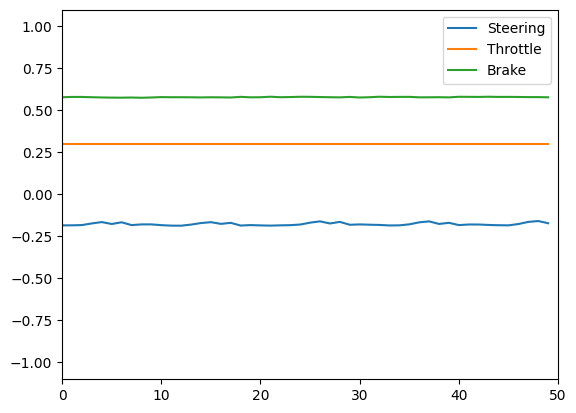

In [2]:
import carla
import time
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import deque
import cv2

# Connect to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.get_world()

# Set synchronous mode
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.05
world.apply_settings(settings)

# Get blueprint library and spawn ego vehicle
blueprint_library = world.get_blueprint_library()
vehicle_bp = blueprint_library.find('vehicle.mini.cooper')
spawn_point = world.get_map().get_spawn_points()[0]
ego_vehicle = world.spawn_actor(vehicle_bp, spawn_point)

# Add after vehicle is spawned
spectator = world.get_spectator()

# Function to update spectator behind the car
def follow_vehicle():
    transform = ego_vehicle.get_transform()
    location = transform.location + carla.Location(x=-6, z=3)
    rotation = transform.rotation
    spectator.set_transform(carla.Transform(location, rotation))

# Initialize throttle, brake, and steering variables
throttle = 0.0
brake = 0.0
steering = 0.0  # You might want to set this based on the model output

# Camera sensor setup
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '224')
camera_bp.set_attribute('image_size_y', '224')
camera_bp.set_attribute('fov', '110')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=ego_vehicle)

# Load trained model
class DrivingModel(torch.nn.Module):
    def __init__(self):
        super(DrivingModel, self).__init__()
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(3, 24, kernel_size=5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(24, 36, kernel_size=5, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(36, 64, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64 * 51 * 51, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 3)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

model = DrivingModel()
model.load_state_dict(torch.load("driving_model.pth", map_location=torch.device("cpu")))
model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
window_size = 50
steering_history = deque(maxlen=window_size)
throttle_history = deque(maxlen=window_size)
brake_history = deque(maxlen=window_size)
line1, = ax.plot([], [], label='Steering')
line2, = ax.plot([], [], label='Throttle')
line3, = ax.plot([], [], label='Brake')
ax.set_ylim([-1.1, 1.1])
ax.set_xlim([0, window_size])
ax.legend()

# Camera image holder
image_data = {"frame": None}

def process_image(image):
    array = np.frombuffer(image.raw_data, dtype=np.uint8).reshape((image.height, image.width, 4))
    image_data["frame"] = array[:, :, :3]

camera.listen(lambda image: process_image(image))

print("Running... Press Ctrl+C to stop.")
try:
    while True:
        world.tick()
        if image_data["frame"] is None:
            continue

        # Get latest frame
        frame = image_data["frame"]
        pil_image = Image.fromarray(frame)
        input_tensor = transform(pil_image).unsqueeze(0)

        # Predict control values
        with torch.no_grad():
            output = model(input_tensor)[0].numpy()
        steering, throttle, brake = output

        # Sanitize output
        steering = float(np.clip(steering, -1.0, 1.0))
        throttle = float(torch.sigmoid(torch.tensor(throttle)).item())
        brake = float(torch.sigmoid(torch.tensor(brake)).item())

        # Override low throttle
        if throttle < 0.1:
            throttle = 0.2
        if brake > 0.2:
            throttle = 0.0

        print(f"[DEBUG] Steering: {steering:.2f}, Throttle: {throttle:.2f}, Brake: {brake:.2f}")

        # Force initial motion if throttle is too low
        if throttle < 0.1:
            throttle = 0.3  # Force boost

        # Apply control logic
        control = carla.VehicleControl()
        control.steer = steering
        control.throttle = throttle
        control.brake = brake
        ego_vehicle.apply_control(control)

        # Follow vehicle with spectator
        follow_vehicle()

        # Update plot
        steering_history.append(steering)
        throttle_history.append(throttle)
        brake_history.append(brake)
        line1.set_ydata(list(steering_history))
        line2.set_ydata(list(throttle_history))
        line3.set_ydata(list(brake_history))
        line1.set_xdata(range(len(steering_history)))
        line2.set_xdata(range(len(throttle_history)))
        line3.set_xdata(range(len(brake_history)))
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(0.03)

except KeyboardInterrupt:
    print("Exiting...")

finally:
    camera.stop()
    ego_vehicle.destroy()
    settings.synchronous_mode = False
    world.apply_settings(settings)
    print("Cleaned up.")
